In [1]:
import sys
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, clear_output, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../experiments/data/interim/DIJA-2006-2018-clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

In [3]:
df.head()

Open   High    Low  Close Name
Date                                       
2006-01-03  77.76  79.35  77.24  79.11  MMM
2006-01-04  79.49  79.49  78.25  78.71  MMM
2006-01-05  78.41  78.65  77.56  77.99  MMM
2006-01-06  78.64  78.90  77.64  78.63  MMM
2006-01-09  78.50  79.83  78.46  79.02  MMM

In [21]:
from hedgepy.core import HedgeFrame
from memoization import cached

@cached 
def build_dcor_network(df, ticker_col_name, rolling_window=90):
    hf = HedgeFrame(df=df, ticker_col_name=ticker_col_name)
    _90d_dcor_network = hf.dcor(rolling_window=rolling_window)
    return _90d_dcor_network
# @cached
# def build_correlation_matrix_time_series(df, ticker_col_name, rolling_window):
#     hf = HedgeFrame(df, ticker_col_name)
#     numpy_time_series_dict = hf.build_correlation_matrix_time_series(rolling_window=rolling_window)
#     return numpy_time_series_dict
    

# _90d_dcor_network = hf.build_dcor_network_time_series(rolling_window=90)

In [20]:
_90d_dcor_network = build_dcor_network(df, 'Name', 90)

In [33]:
from hedgepy.utils import read, write

write(_90d_dcor_network, 'dija_2006-18-rolling_90d_dcor.json')

In [37]:
read('dija_2006-18-rolling_90d_dcor')

{Timestamp('2006-05-12 00:00:00'):         AABA      AAPL      AMZN       AXP        BA       CAT      CSCO  \
 0   1.000000  0.441549  0.532203  0.480009  0.350722  0.342745  0.411951   
 1   0.441549  1.000000  0.373954  0.359973  0.309873  0.311575  0.342581   
 2   0.532203  0.373954  1.000000  0.375458  0.303114  0.353570  0.391915   
 3   0.480009  0.359973  0.375458  1.000000  0.340410  0.459975  0.454669   
 4   0.350722  0.309873  0.303114  0.340410  1.000000  0.412086  0.284633   
 5   0.342745  0.311575  0.353570  0.459975  0.412086  1.000000  0.404129   
 6   0.411951  0.342581  0.391915  0.454669  0.284633  0.404129  1.000000   
 7   0.276736  0.327277  0.274344  0.313534  0.292250  0.376331  0.267032   
 8   0.367528  0.426146  0.304423  0.404556  0.324156  0.331851  0.408888   
 9   0.362583  0.382770  0.403550  0.409795  0.400672  0.367301  0.394035   
 10  0.544332  0.415756  0.375580  0.379780  0.378068  0.377500  0.308005   
 11  0.492853  0.382382  0.481335  0.47216

In [25]:
keys = list(_90d_dcor_network.keys())
values = list(_90d_dcor_network.values())

keys = map(lambda timestamp: str(timestamp), keys)
values = map(lambda df: df.to_dict('records'), values)

_90d_dcor_network_json = dict(zip(keys,values))

In [27]:
import json
with open('_90d_dcor_network.json', 'w') as f:
    json.dump(_90d_dcor_network_json, f)

In [71]:
# from hedgepy.core import build_correlation_network
# import networkx as nx

# @cached
# def build_global_clustering_time_series(nx_time_series, corr_threshold=None):
#     nx_network_time_series = {
#         time_series: build_correlation_network(df_dcor, corr_threshold=corr_threshold)
#         for time_series, df_dcor in nx_time_series.items()
#     }
    
#     global_clustering_ts = {
#         timestamp: nx.average_clustering(df, weight='weight') for timestamp, df in nx_network_time_series.items()
#     }
    
#     return global_clustering_ts

In [65]:
# frame = build_correlation_matrix_time_series(df, 'Name', rolling_window=90)

In [69]:
global_clustering_ts = build_global_clustering_time_series(frame)
df_clustering = pd.DataFrame.from_dict(global_clustering_ts, orient='index')\
        .rename(columns={0: '90d_global_clustering_coefficient'})

In [38]:
df_clustering.head()

90d_global_clustering_coefficient
2006-05-12                           0.453719
2006-05-15                           0.472583
2006-05-16                           0.474465
2006-05-17                           0.469718
2006-05-18                           0.466833

In [14]:
import networkx as nx
from scipy.stats import mstats

def average_communicability_betweenness(G):
    cbc = nx.communicability_betweenness_centrality(G)
    average_cbc = np.mean(list(cbc.values()))
    return average_cbc

def average_degree_centrality(G):
    dc = nx.degree_centrality(G)
    avg_dc = np.mean(list(dc.values()))
    return avg_dc

def average_eigenvector_centrality(G):
    ec = nx.eigenvector_centrality(G, weight='weight')
    avg_ec = mstats.gmean(list(ec.values()))
    return avg_ec

nx_time_series = {
    timestamp: average_eigenvector_centrality(dcor_network) 
     for timestamp, dcor_network in _90d_dcor_network.items()
}

# nx_time_series = {
#     timestamp: average_eigenvector_centrality(dcor_network) 
#      for timestamp, dcor_network in _90d_dcor_network.items()
# }
    
df_clustering = pd.DataFrame.from_dict(nx_time_series, orient='index')\
    .rename(columns={0: '90d_global_clustering_coefficient'})

AttributeError: 'DataFrame' object has no attribute 'is_directed'

In [216]:
test = df_clustering.to_numpy()
df_test = pd.DataFrame(test)
df_test.columns = df_clustering.columns
df_test.index = df_clustering.index

In [217]:
df_test.head()

90d_global_clustering_coefficient
2006-05-12                           0.037676
2006-05-15                           0.033724
2006-05-16                           0.017135
2006-05-17                           0.057661
2006-05-18                           0.085318

In [6]:
# df_clustering.to_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-eigenvector-soft-thresh.csv')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

In [4]:
df_dija_index = pd.read_csv('../experiments/data/raw/DIJA-index-2006-2018.csv')

In [5]:
df_dija_index['Date'] = pd.to_datetime(df_dija_index['Date'])

In [6]:
df_dija_index.set_index('Date', inplace=True)

In [7]:
dft = pd.read_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-eigenvector-soft-thresh.csv')
dft = dft.rename(columns={'Unnamed: 0': 'Date'})
dft['Date'] = pd.to_datetime(dft['Date'])
dft.set_index('Date', inplace=True)

In [28]:
test = df_dija_index['Close'].pct_change().rolling(30).std()

Text(0, 0.5, 'DIJA Index')

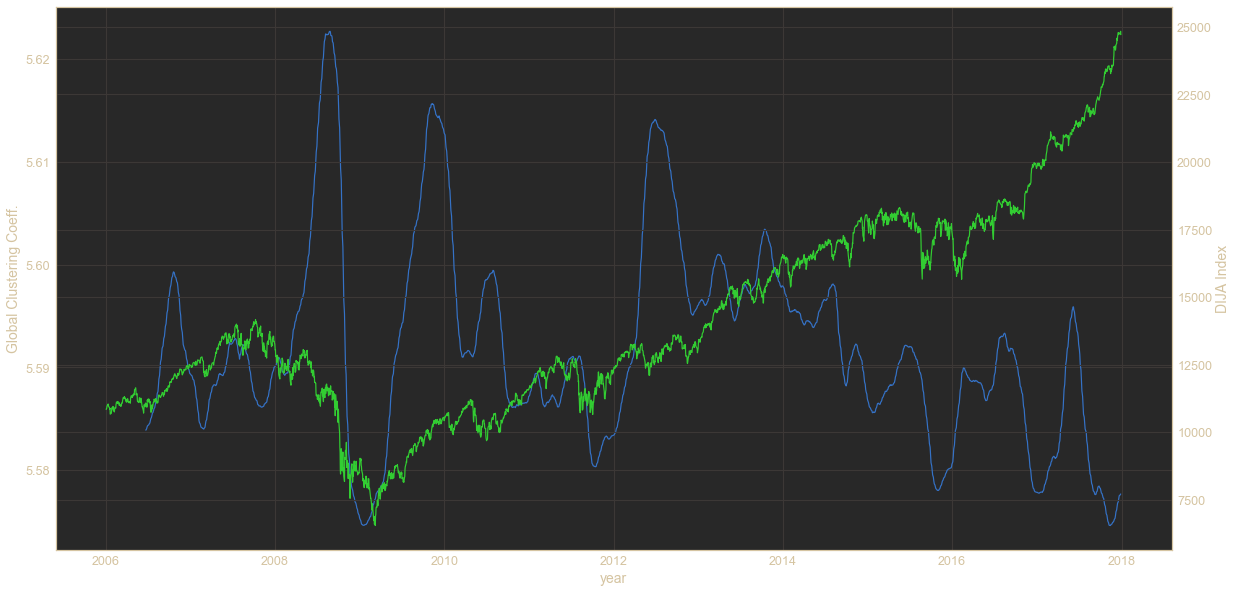

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(1/dft.rolling(30).mean())
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("Global Clustering Coeff.", fontsize=14)

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)

In [16]:
(1/dft['90d_global_clustering_coefficient']).corr(df_dija_index['Close'])

-0.2867000472712344

In [256]:
dft = df_clustering

In [305]:
dft_pos = dft.pct_change()[dft.pct_change()['90d_global_clustering_coefficient'] >=0]

In [335]:
# dft_pos.columns = ['crisis_coeff']
# dft_pos.dropna(inplace=True)

In [39]:
dft['crisis_coeff'] = dft[['90d_global_clustering_coefficient']].pct_change()

In [109]:
dft = dft.replace([np.inf, -np.inf], np.nan)

In [40]:
dft.dropna(inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math

def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [41]:
data = dft[['crisis_coeff']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(data, n=20)

searching for optimal hyperparameters...


In [42]:
opt_nu

0.006845263157894737

In [43]:
opt_gamma

0.00010615789473684212

In [271]:
p = 1/len(dft)

In [44]:
#train OneClassSVM
model = OneClassSVM(nu=0.02, kernel="rbf", gamma=opt_gamma)
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [273]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.001, behaviour='new')
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [45]:
dft['anomaly'] = anomalies

In [46]:
dft['dija'] = df_dija_index['Close']

In [50]:
size=np.abs([(i*10000)*1.5 for i in a['crisis_coeff'].tolist()])
size

array([ 625.        ,  688.0733945 ,  625.        ,  557.14285714,
        545.45454545,  637.25490196,  693.06930693,  934.25605536,
        735.8490566 ,  549.45054945,  786.51685393, 3192.77108434,
       1192.05298013, 1165.04854369,  837.05357143,  620.4379562 ,
        629.37062937,  546.11650485, 1804.81283422,  700.93457944,
        668.31683168,  653.84615385, 1098.5915493 ,  592.59259259,
        665.68047337,  709.09090909,  681.81818182,  910.54313099,
       1718.75      ,  588.23529412, 1285.71428571,  557.43243243,
       1105.26315789,  550.        , 1259.54198473,  732.8990228 ,
        704.69798658,  568.96551724, 1166.66666667,  952.38095238,
        572.03389831,  558.13953488, 1449.27536232,  594.71365639,
        557.85123967,  579.39914163,  602.67857143,  666.66666667,
       1480.68669528, 1034.48275862,  675.        ,  668.31683168,
        849.05660377,  649.35064935,  684.6473029 ,  652.17391304,
        666.66666667,  767.44186047])

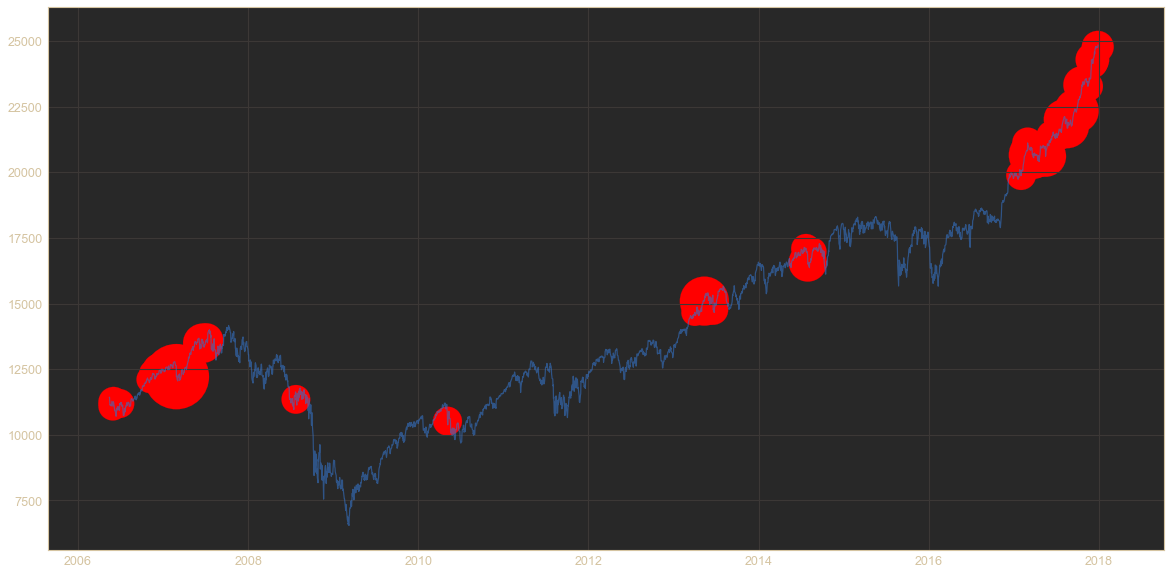

In [49]:
a = dft.loc[dft['anomaly'] == -1]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['dija'], label='Normal', alpha=0.6)
ax.scatter(a.index, dft['dija'][dft['anomaly']==-1], color='red', label='Anomaly', s=size)

In [52]:
dft[(dft['anomaly'] == -1)]

90d_global_clustering_coefficient  crisis_coeff  anomaly  \
Date                                                                   
2006-05-30                           0.752688      0.041667       -1   
2006-06-02                           0.735484      0.045872       -1   
2006-06-29                           0.860215      0.041667       -1   
2006-11-06                           0.724731     -0.037143       -1   
2006-11-17                           0.683871     -0.036364       -1   
2006-11-24                           0.630108     -0.042484       -1   
2006-11-28                           0.681720      0.046205       -1   
2006-12-18                           0.582796     -0.062284       -1   
2006-12-22                           0.597849      0.049057       -1   
2007-01-18                           0.565591     -0.036630       -1   
2007-02-08                           0.544086     -0.052434       -1   
2007-02-27                           0.649462      0.212851       -1   
2007-02-28                           0.701075      0.079470       -1   
2007-06-20                           0.954839      0.077670       -1   
2007-07-06                           0.909677     -0.055804       -1   
2008-07-24                           0.847312     -0.041363       -1   
2010-05-06                           0.961290      0.041958       -1   
2013-04-02                           0.853763     -0.036408       -1   
2013-05-13                           0.707527     -0.120321       -1   
2013-05-23                           0.722581      0.046729       -1   
2013-06-20                           0.907527      0.044554       -1   
2014-07-23                           0.802151     -0.043590       -1   
2014-07-31                           0.819355      0.073239       -1   
2014-08-20                           0.836559     -0.039506       -1   
2017-02-01                           0.694624     -0.044379       -1   
2017-03-01                           0.619355      0.047273       -1   
2017-03-03                           0.643011      0.045455       -1   
2017-03-20                           0.632258     -0.060703       -1   
2017-03-23                           0.548387     -0.114583       -1   
2017-03-24                           0.526882     -0.039216       -1   
2017-03-27                           0.572043      0.085714       -1   
2017-04-21                           0.612903     -0.037162       -1   
2017-04-24                           0.658065      0.073684       -1   
2017-04-27                           0.621505     -0.036667       -1   
2017-05-17                           0.610753      0.083969       -1   
2017-06-14                           0.627957     -0.048860       -1   
2017-07-10                           0.610753     -0.046980       -1   
2017-07-19                           0.600000     -0.037931       -1   
2017-08-02                           0.535484     -0.077778       -1   
2017-08-04                           0.507527     -0.063492       -1   
2017-08-07                           0.488172     -0.038136       -1   
2017-08-16                           0.445161     -0.037209       -1   
2017-08-17                           0.488172      0.096618       -1   
2017-08-18                           0.507527      0.039648       -1   
2017-08-24                           0.501075     -0.037190       -1   
2017-08-25                           0.481720     -0.038627       -1   
2017-08-28                           0.501075      0.040179       -1   
2017-08-30                           0.505376      0.044444       -1   
2017-09-27                           0.451613     -0.098712       -1   
2017-10-20                           0.466667      0.068966       -1   
2017-11-15                           0.449462      0.045000       -1   
2017-11-30                           0.453763      0.044554       -1   
2017-12-04                           0.481720      0.056604       -1   
2017-12-06                           0.518280      0

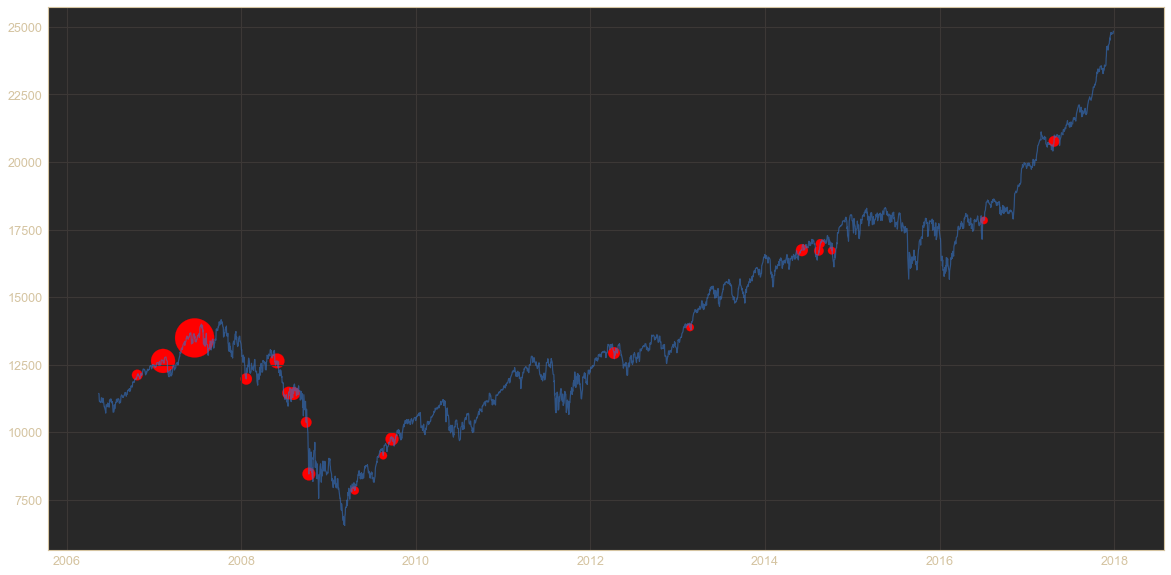

In [340]:
a = dft.loc[dft['anomaly'] == -1]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['dija'], label='Normal', alpha=0.6)
ax.scatter(a.index, dft['dija'][dft['anomaly']==-1], color='red', label='Anomaly', s=size)

# ax2 = ax.twinx()
# ax2.plot(df_dija_index['Close'], color='limegreen')
# ax2.set_ylabel('DIJA Index', fontsize=14)
# plt.legend()

In [119]:
from hurst import compute_Hc
H, c, dta =  compute_Hc(dft['90d_global_clustering_coefficient'])

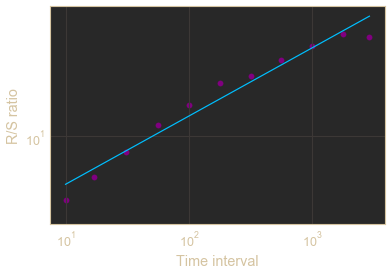

H=0.4269, c=1.8719


In [120]:
f, ax = plt.subplots()
ax.plot(dta[0], c*dta[0]**H, color="deepskyblue")
ax.scatter(dta[0], dta[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [267]:
dft[(dft['anomaly'] == -1)]

90d_global_clustering_coefficient  crisis_coeff  anomaly  \
2006-10-23                           0.178757      0.000666       -1   
2007-02-08                           0.179043     -0.001275       -1   
2007-06-20                           0.178976      0.001881       -1   
2008-01-22                           0.179047      0.000704       -1   
2008-05-30                           0.178160     -0.000867       -1   
2008-07-17                           0.177713     -0.000763       -1   
2008-08-07                           0.178005      0.000771       -1   
2008-09-29                           0.178450      0.000668       -1   
2008-10-10                           0.178982      0.000772       -1   
2009-04-20                           0.178993     -0.000543       -1   
2009-08-17                           0.178315     -0.000519       -1   
2009-09-23                           0.178203      0.000782       -1   
2012-04-09                           0.178516     -0.000724       -1   
2013-02-21                           0.178504     -0.000512       -1   
2014-06-04                           0.178733      0.000731       -1   
2014-08-14                           0.178847      0.000614       -1   
2014-08-20                           0.178960      0.000587       -1   
2014-10-07                           0.178725     -0.000514       -1   
2016-07-05                           0.178758     -0.000504       -1   
2017-04-24                           0.178795     -0.000671       -1   

                    dija  
2006-10-23  12116.910160  
2007-02-08  12637.629880  
2007-06-20  13489.419920  
2008-01-22  11971.190430  
2008-05-30  12638.320310  
2008-07-17  11446.660160  
2008-08-07  11431.429690  
2008-09-29  10365.450200  
2008-10-10   8451.190430  
2009-04-20   7841.729980  
2009-08-17   9135.339844  
2009-09-23   9748.549805  
2012-04-09  12929.589840  
2013-02-21  13880.620120  
2014-06-04  16737.529300  
2014-08-14  16713.580080  
2014-08-20  16979.130860  
2014-10-07  16719.390630  
2016-07-05  17840.619140  
2017-04-24  20763.890630

2020-04-28 23:06:49,975 [23416] WARNING  matplotlib.legend:1282: [JupyterRequire] No handles with labels found to put in legend.


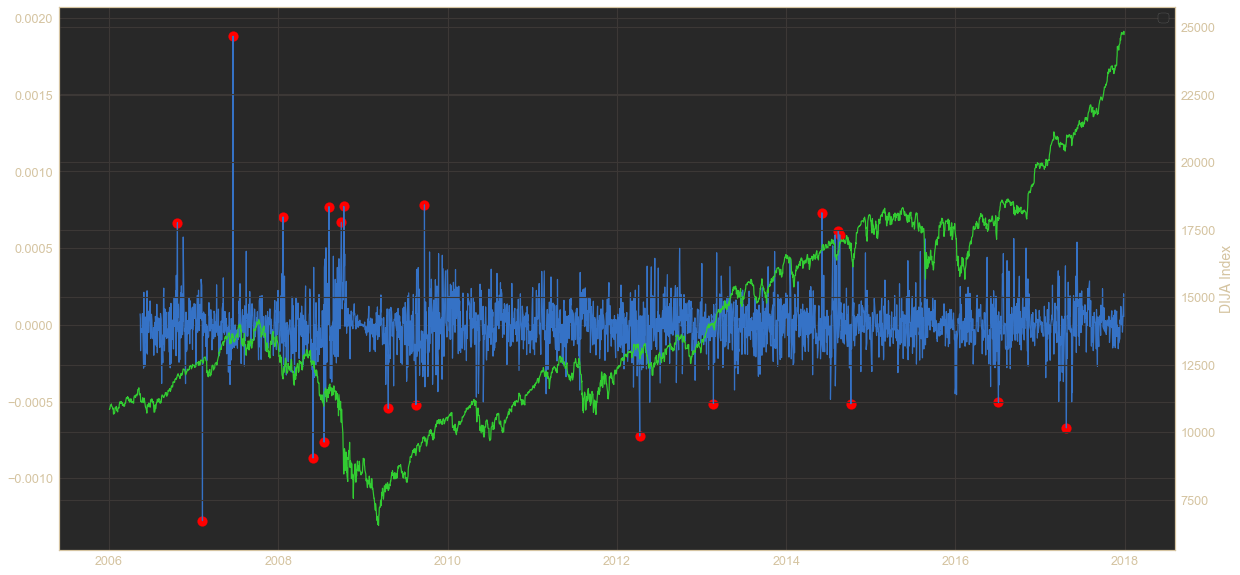

In [291]:
a = dft.loc[dft['anomaly'] == -1, ['crisis_coeff']]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['crisis_coeff'], label='Normal')
ax.scatter(a.index, a['crisis_coeff'], color='red', label='Anomaly')

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
plt.legend()

In [207]:
dft[(dft['anomaly'] == -1)] 

90d_global_clustering_coefficient  crisis_coeff  anomaly  \
2006-06-28                           0.000000     -1.000000       -1   
2006-07-12                           0.000000     -1.000000       -1   
2006-08-04                           0.073451      2.635851       -1   
2006-10-23                           0.055812     -0.656718       -1   
2006-10-24                           0.109258      0.957600       -1   
2006-11-09                           0.000000     -1.000000       -1   
2007-04-10                           0.000000     -1.000000       -1   
2007-06-28                           0.114622      1.272159       -1   
2007-07-18                           0.000000     -1.000000       -1   
2007-07-20                           0.000000     -1.000000       -1   
2007-07-25                           0.000000     -1.000000       -1   
2007-08-08                           0.137870      0.901305       -1   
2011-02-28                           0.000000     -1.000000       -1   
2011-04-12                           0.112971      0.871408       -1   
2011-04-14                           0.151313      1.505955       -1   
2013-04-02                           0.064131     -0.657533       -1   
2013-05-13                           0.000000     -1.000000       -1   
2013-05-29                           0.091658      0.840366       -1   
2014-03-03                           0.110839      2.066859       -1   
2014-08-26                           0.183096      1.754842       -1   
2016-11-23                           0.152958      0.908339       -1   
2017-02-02                           0.000000     -1.000000       -1   
2017-02-23                           0.000000     -1.000000       -1   
2017-03-01                           0.108981      1.275943       -1   
2017-06-15                           0.182201      1.133738       -1   
2017-12-27                           0.000000     -1.000000       -1   

                   dija  
2006-06-28  10973.55957  
2006-07-12  11013.17969  
2006-08-04  11240.34961  
2006-10-23  12116.91016  
2006-10-24  12127.87988  
2006-11-09  12103.29981  
2007-04-10  12573.84961  
2007-06-28  13422.28027  
2007-07-18  13918.21973  
2007-07-20  13851.08008  
2007-07-25  13785.07031  
2007-08-08  13657.86035  
2011-02-28  12226.33984  
2011-04-12  12263.58008  
2011-04-14  12285.15039  
2013-04-02  14662.00977  
2013-05-13  15091.67969  
2013-05-29  15302.79981  
2014-03-03  16168.03027  
2014-08-26  17106.69922  
2016-11-23  19083.17969  
2017-02-02  19884.91016  
2017-02-23  20810.32031  
2017-03-01  21115.55078  
2017-06-15  21359.90039  
2017-12-27  24774.30078

In [265]:
import ipyhc as hc

dija_index_series = hc.build.series(df_dija_index[['Close']])
df_clustering_series = hc.build.series(dft[['90d_global_clustering_coefficient']])

In [266]:
df_clustering_series[0]['yAxis'] = 1

In [267]:
options = {
    'credits': {'enabled': True,
                'text': 'Source: XXX Flow Strategy & Solutions.',
                'href': 'http://www.example.com'},
    'exporting': {'enabled': True},
    'chart': {'zoomType': 'xy'},
    'plotOptions': {'series': {'compare': 'percent'}},
    'legend': {'enabled': True,
               'layout': 'horizontal',
               'align': 'center',
               'maxHeight': 100},
    'tooltip': {'enabled': True,
                'valueDecimals': 5,
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'positioner': "function(labelWidth, labelHeight, point) {\n    var roundUp100 = function(d) { return 100*Math.floor(d/100); },\n        labelWidth = roundUp100(labelWidth),\n        chart = window.charts['__uuid__'];\n\n    var tooltipX, tooltipY;\n        var testX = (point.plotX + labelWidth * 0.7 > chart.plotWidth / 2) && (point.plotX - labelWidth * 0.7 < chart.plotWidth / 2);\n        var testY = point.plotY < labelHeight * 0.7;\n\n    if (testX && testY) {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop + chart.plotHeight - labelHeight;\n    } else {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop;\n    }\n\n    return {\n        x: tooltipX,\n        y: tooltipY\n    };\n}\n\n"},
    'title': {'text': 'Time series plotted with HighStock'},
    'subtitle': {'text': 'Transparent access to the underlying js lib'},
    'yAxis': [
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
        },
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
            'title': {
                'text': '% change'
            }
        }
    ],
    'xAxis': {
        'gridLineWidth': 1.0, 
        'gridLineDashStyle': 'Dot'},
}

chart = hc.Chart(height=600, width=1200, stock = True, options = options, data = dija_index_series + df_clustering_series)
chart

Chart(height='600px', stock=True, width='1200px')

In [74]:
from alpha_vantage.timeseries import TimeSeries
key = '34CW4J294SBIRRAM'
ts = TimeSeries(key, output_format='pandas')
aapl_data, aapl_meta_data = ts.get_daily(symbol='AMZN', outputsize='full')

ValueError: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.

In [73]:
aapl_data.head()

1. open  2. high  3. low  4. close  5. volume
date                                                     
2000-04-28    54.00    55.63   53.13     55.19  6833800.0
2000-05-01    56.00    60.31   55.25     59.94  8578500.0
2000-05-02    59.19    60.00   55.88     56.13  7427900.0
2000-05-03    55.25    56.56   53.00     54.13  5424800.0
2000-05-04    54.25    56.50   53.13     55.06  4725200.0

In [66]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5032 entries, 2000-04-28 to 2020-04-29
Data columns (total 5 columns):
1. open      5032 non-null float64
2. high      5032 non-null float64
3. low       5032 non-null float64
4. close     5032 non-null float64
5. volume    5032 non-null float64
dtypes: float64(5)
memory usage: 235.9 KB
